In [1]:
using CSV, DataFrames
using FileIO, Dates
using Graphs, MetaGraphs
using DataStructures
using PyCall
using Plots
using DelimitedFiles
using StatsBase
using LinearAlgebra

include("./src/cubes.jl")
include("./src/network.jl")
include("./src/motifs_analysis.jl")

volume_tetrahedrons (generic function with 1 method)

In [2]:
# Read data
path = "./data/"
region = "california"
filepath = path * region * ".csv"

df = CSV.read(filepath, DataFrame);


# Based on parameter dependency, extract which side lengths are the best:
if region == "romania"
    sides = [3, 4, 5];
elseif region == "california"
    sides = [1, 1.5, 2];
elseif region == "italy"
    sides = [5, 7.5, 10];
elseif region == "japan"
    sides = [3, 4, 5];
end;


In [3]:
# for side in sides
#     # Make target path for results
#     network_target_path = "./networks/$(region)/side_$(string(side))km/"
#     mkpath(network_target_path)

#     for minimum_magnitude in [0, 1, 2, 3, 4]
#         # filter database based on minimum Magnitude
#         df_filtered = df[df.Magnitude .> minimum_magnitude,:] 

#         # Split into cubes
#         df_filtered, df_filtered_cubes = region_cube_split(df_filtered,side=side,energyRelease=true);

In [9]:
side = sides[1]
minimum_magnitude = 2
df_filtered = df[df.Magnitude .> minimum_magnitude,:] 

# Split into cubes
df_filtered, df_filtered_cubes = region_cube_split(df_filtered,side=side,energyRelease=true);

motif="Tetrahedron"

# Get the motif
network_target_path = "./networks/$(region)/side_$(string(side))km/"
motif_filename = "motif$(motif)_$(region)_side_$(string(side))km_minmag_$(string(minimum_magnitude)).csv"

# motifs = CSV.read(network_target_path * motif_filename, DataFrame);
motifs = readdlm(network_target_path * motif_filename, ',', Int64);


mkpath("./motifs/$region")

"./motifs/california"

In [10]:
motif_energy = total_mean_energy(motifs, df_filtered, df_filtered_cubes);
# areas = area_triangles(motifs, df_filtered_cubes);
volumes = volume_tetrahedrons(motifs,df_filtered_cubes)

volume = [value for value in values(volumes)];
totalenergy = [value[1] for value in values(motif_energy)]
meanenergy = [value[2] for value in values(motif_energy)];

In [11]:
volume_weight_totalenergy = []
volume_weight_meanenergy = []
for key in keys(motif_energy)
    # Used to filter out zeros and very small areas (triangles on the vertical for example)
    if volumes[key] > 1
        push!(volume_weight_totalenergy, volumes[key]/motif_energy[key][1])
        push!(volume_weight_meanenergy, volumes[key]/motif_energy[key][2])
    end
end

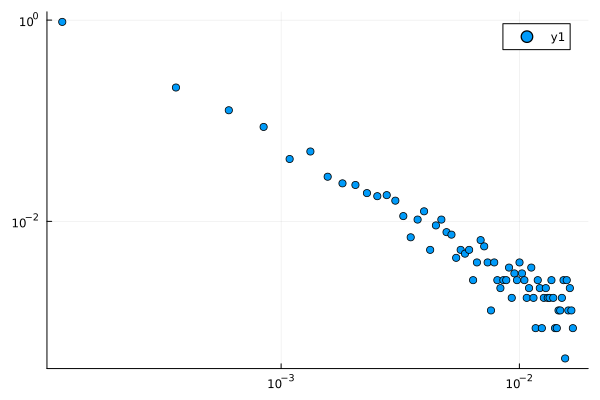

In [12]:
fit_data = volume_weight_totalenergy;

bstep = 2 * iqr(fit_data) * length(fit_data) ^ (-1/3)
b = minimum(fit_data) : bstep : maximum(fit_data)
h = StatsBase.fit(Histogram{Float64}, fit_data, b)

# Collect bin edges and calculate middle between each 2 points
xx = collect(h.edges[1])
x=[]
for i in eachindex(xx[1:end-1])
    push!(x,(xx[i]+xx[i+1])/2)
end
# Results x, the middle of each bin

# Collect bin weights (number of counts in each bin)
y = h.weights

# Code for stoping at first zero (apply to both vectors)
y_nozero=[]
x_nozero=[]
for i in eachindex(y)
    if y[i] == 0.0
        y_nozero = y[1:i-1]
        x_nozero = x[1:i-1]
        break
    end
end

# Normalize the bin weights (so they add up to 1)
y_nozero_norm = normalize(y_nozero);

Plots.scatter(x_nozero,y_nozero_norm,xscale=:log10,yscale=:log10)
Plots.savefig("./motifs/$region/motif$(motif)_$(region)_side_$(string(side))km_minmag_$(string(minimum_magnitude))_volume_weight_totalenergy_histogram.png")
current()

In [14]:
@pyimport powerlaw as powlaw

In [16]:
fit_volume_weight_totalenergy = powlaw.Fit(volume_weight_totalenergy, xmin=0.01);
# fit_area_weight_meanenergy = powlaw.Fit(area_weight_meanenergy);

PyObject <powerlaw.Fit object at 0x7f94a39898e0>

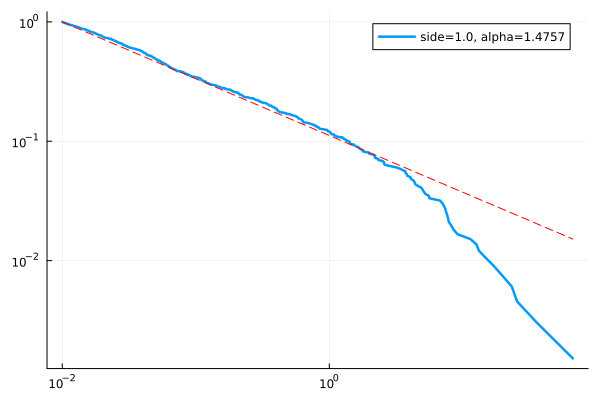

In [18]:
alpha = round(fit_volume_weight_totalenergy.alpha,digits=4)

# CCDF of data truncated
x_ccdf, y_ccdf = fit_volume_weight_totalenergy.ccdf()
Plots.plot(x_ccdf, y_ccdf, xscale=:log10, yscale=:log10, label="side=$side, alpha=$alpha", linewidth=2.5)

# Theoretical power_law

fit_volume_weight_totalenergy_power_law = fit_volume_weight_totalenergy.power_law.plot_ccdf()[:lines][1]
x_powlaw, y_powlaw = fit_volume_weight_totalenergy_power_law[:get_xdata](), fit_volume_weight_totalenergy_power_law[:get_ydata]()
Plots.plot!(x_powlaw, y_powlaw, xscale=:log10, yscale=:log10, label="", color=:red, linestyle=:dash)

current()
Plots.savefig("./motifs/$region/motif$(motif)_$(region)_side_$(string(side))km_minmag_$(string(minimum_magnitude))_volume_weight_totalenergy.png")
current()

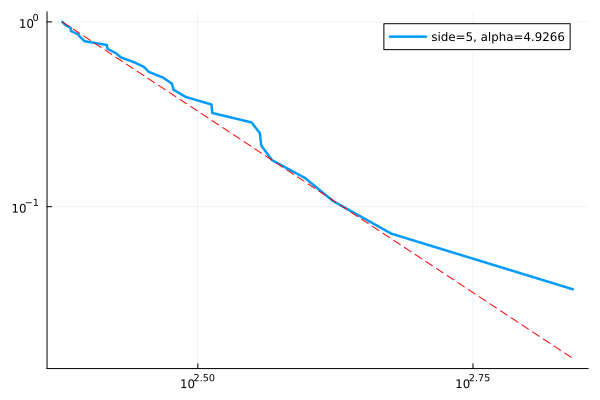

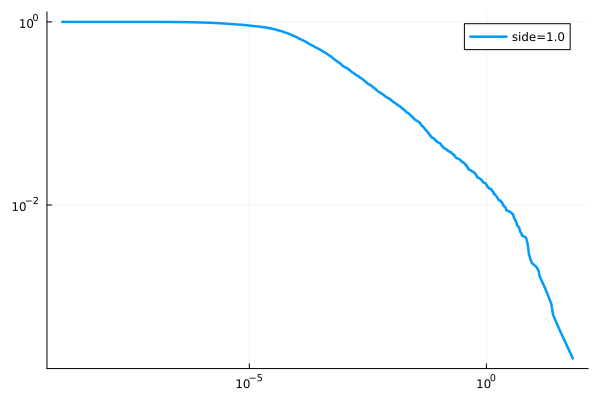

In [19]:
# CCDF of data truncated
x_ccdf, y_ccdf = fit_volume_weight_totalenergy.ccdf(original_data=true)
Plots.plot(x_ccdf, y_ccdf, xscale=:log10, yscale=:log10, label="side=$side", linewidth=2.5)

In [ ]:
# alpha = round(fit_area_weight_meanenergy.alpha,digits=4)

# # CCDF of data truncated
# x_ccdf, y_ccdf = fit_area_weight_meanenergy.ccdf()
# Plots.plot(x_ccdf, y_ccdf, xscale=:log10, yscale=:log10, label="side=$side, alpha=$alpha", linewidth=2.5)

# # Theoretical power_law

# fit_area_weight_meanenergy_power_law = fit_area_weight_meanenergy.power_law.plot_ccdf()[:lines][1]
# x_powlaw, y_powlaw = fit_area_weight_meanenergy_power_law[:get_xdata](), fit_area_weight_meanenergy_power_law[:get_ydata]()
# Plots.plot!(x_powlaw, y_powlaw, xscale=:log10, yscale=:log10, label="", color=:red, linestyle=:dash)

# Plots.savefig("./motifs/$region/motif$(motif)_$(region)_side_$(string(side))km_minmag_$(string(minimum_magnitude))_area_weight_meanenergy.png")
# current()


# # CCDF of data truncated
# x_ccdf, y_ccdf = fit_area_weight_meanenergy.ccdf(original_data=true)
# Plots.plot(x_ccdf, y_ccdf, xscale=:log10, yscale=:log10, label="side=$side", linewidth=2.5)